## Import Library

In [1]:
import os
import io
import gdown
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

2025-05-27 12:49:05.872340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748350146.052076      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748350146.100617      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Get Dataset 

In [2]:
# Download zip file dataset from url

# SIBI datasets : https://drive.google.com/file/d/1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv/view?usp=sharing
!gdown 1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv

Downloading...
From (original): https://drive.google.com/uc?id=1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv
From (redirected): https://drive.google.com/uc?id=1S3qe0CUb0Ti5ijmquScydP8s67Gu31Zv&confirm=t&uuid=7b231636-7ecc-495c-9e3b-cc1617944a5d
To: /kaggle/working/SIBI_datasets.zip
100%|████████████████████████████████████████| 780M/780M [00:07<00:00, 98.8MB/s]


In [3]:
# Unzip dataset
!unzip SIBI_datasets.zip

Archive:  SIBI_datasets.zip
   creating: SIBI_datasets/
   creating: SIBI_datasets/val/
   creating: SIBI_datasets/val/U/
  inflating: SIBI_datasets/val/U/2871.jpg  
  inflating: SIBI_datasets/val/U/2555.jpg  
  inflating: SIBI_datasets/val/U/U2579.jpg  
  inflating: SIBI_datasets/val/U/U2807.jpg  
  inflating: SIBI_datasets/val/U/U2395.jpg  
  inflating: SIBI_datasets/val/U/590.jpg  
  inflating: SIBI_datasets/val/U/U1446.jpg  
  inflating: SIBI_datasets/val/U/U884.jpg  
  inflating: SIBI_datasets/val/U/2455.jpg  
  inflating: SIBI_datasets/val/U/U774.jpg  
  inflating: SIBI_datasets/val/U/U2062.jpg  
  inflating: SIBI_datasets/val/U/U208.jpg  
  inflating: SIBI_datasets/val/U/U1617.jpg  
  inflating: SIBI_datasets/val/U/2385.jpg  
  inflating: SIBI_datasets/val/U/U190.jpg  
  inflating: SIBI_datasets/val/U/U107.jpg  
  inflating: SIBI_datasets/val/U/2966.jpg  
  inflating: SIBI_datasets/val/U/U289.jpg  
  inflating: SIBI_datasets/val/U/U1612.jpg  
  inflating: SIBI_datasets/val/U/U25

In [4]:
# Delete zip file
file_path = '/kaggle/working/SIBI_datasets.zip'
if os.path.exists(file_path):
    os.remove(file_path)
    print("File SIBI_datasets.zip deleted successfully.")
else:
    print("File SIBI_datasets.zip doesn't exist.")

File SIBI_datasets.zip deleted successfully.


In [5]:
# Show data distribution
data_dir = '/kaggle/working/SIBI_datasets'

data = []
split_folders = ([name for name in os.listdir(data_dir)])

for split in split_folders:
    alphabets = sorted(os.listdir(os.path.join(data_dir, split)))
    for alphabet in alphabets:
        img_files = os.listdir(os.path.join(data_dir,split,alphabet))
        num_imgs = len(img_files)
        data.append({'Folder': split, 'Alfabet': alphabet, 'Jumlah': num_imgs})
df = pd.DataFrame(data)

print("-- Distribusi SIBI Dataset --\n")

x = df.pivot(index='Alfabet', columns='Folder', values='Jumlah').reset_index()
x.columns.name = None
print(x)

# Mengelompokkan data untuk melihat jumlah gambar pada setiap folder
groupby_df = df.groupby('Folder').agg({'Jumlah': 'sum'}).reset_index()

print(f"\n{groupby_df}")
print(f"\nTotal gambar: {groupby_df['Jumlah'].sum()}")

-- Distribusi SIBI Dataset --

   Alfabet  test  train  val
0        A   100    800  100
1        B   100    800  100
2        C   100    800  100
3        D   100    800  100
4        E   100    800  100
5        F   100    800  100
6        G   100    800  100
7        H   100    800  100
8        I   100    800  100
9        J   100    800  100
10       K   100    800  100
11       L   100    800  100
12       M   100    800  100
13       N   100    800  100
14       O   100    800  100
15       P   100    800  100
16       Q   100    800  100
17       R   100    800  100
18       S   100    800  100
19       T   100    800  100
20       U   100    800  100
21       V   100    800  100
22       W   100    800  100
23       X   100    800  100
24       Y   100    800  100
25       Z   100    800  100

  Folder  Jumlah
0   test    2600
1  train   20800
2    val    2600

Total gambar: 26000


In [6]:
# Load Dataset
image_size = (224, 224)
batch_size = 32

train_dir = data_dir +'/train/'
val_dir = data_dir +'/val/'
test_dir = data_dir +'/test/'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                  label_mode='categorical',
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=42)


val_data = tf.keras.utils.image_dataset_from_directory(directory=val_dir,
                                                        label_mode='categorical',
                                                        image_size=image_size,
                                                        batch_size=batch_size,
                                                        shuffle=False)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        label_mode='categorical',
                                                        image_size=image_size,
                                                        batch_size=batch_size,
                                                        shuffle=False)


num_classes = len(train_data.class_names)
class_names = train_data.class_names

print(f"\nClasses {num_classes}: {class_names}")

train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 20800 files belonging to 26 classes.


I0000 00:00:1748350249.059134      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748350249.059847      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2600 files belonging to 26 classes.
Found 2600 files belonging to 26 classes.

Classes 26: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


**Data Augmentation**

In [7]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomBrightness([-0.2,0.2])])

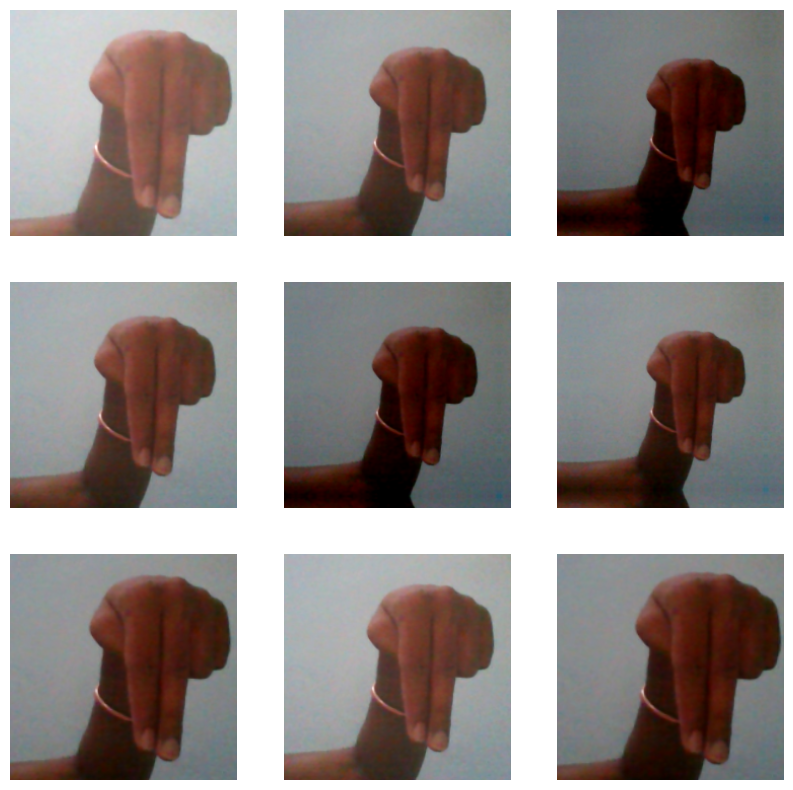

In [8]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Functions

In [9]:
def base_models(base):
    if base == 'resnet':
        print("Instantiating ResNet50 model...")
        base_model = tf.keras.applications.ResNet50(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        
    elif base == 'densenet':
        print("Instantiating DenseNet121 model...")
        base_model = tf.keras.applications.DenseNet121(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        preprocess_input = tf.keras.applications.densenet.preprocess_input
        
    elif base == 'mobilenetv2':
        print("Instantiating MobileNetV2 model...")
        base_model = tf.keras.applications.MobileNetV2(include_top=False,
                            weights='imagenet', input_shape=(224,224,3))
        base_model.trainable = False
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        print("Base model not available")
    return base_model, preprocess_input
    
def custom_model(num_classes, base, dense_layer_units=None):
    base_model, preprocess_input = base_models(base)
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dense_layer_units:
        print(f"Adding additional dense layers with units: {dense_layer_units}")
        for units in dense_layer_units:
            x = tf.keras.layers.Dense(units, activation='relu')(x)
                
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.summary(show_trainable=True)

    print(f"\nCreate model with base model: {base}, dense layer: {dense_layer_units}, classes: {num_classes}")
    
    return model

In [10]:
def train_model(model, train_data, val_data, epoch):
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1,
                                                       patience=5,
                                                       verbose=1,
                                                       min_lr=0.0)
    
    print("\nStart model training...\n")
    history = model.fit(
              train_data,
              validation_data=val_data,
              epochs=epoch,
              verbose=1,
              callbacks=[lr_callback])
    print("\nModel training completed.\n")
    return model, history

def visualize_history(history):
    accuracy = history.history.get('accuracy')
    val_accuracy = history.history.get('val_accuracy')
    
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    epochs_range = range(len(accuracy))
    
    plt.figure(figsize=(12, 4))
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

In [22]:
def evaluate_model(model, test_data):
    testLoss, testAcc = model.evaluate(test_data, verbose=1)
    print(f'Accuracy on test data: {testAcc:.4f}')
    print(f'Loss on test data: {testLoss:.4f}\n')
    
def predict_model(model, test_data, class_names):
    # predict test data
    predictions = model.predict(test_data,verbose=1)
    
    # convert prediction output from probability to predicted class indices (0,1,2)
    predicted_indices = tf.argmax(predictions, axis=1).numpy()
    
    predicted_labels = []
    for predicted_class_index in predicted_indices:
        # Use the predicted index to look up the actual class name
        predicted_label_name = class_names[predicted_class_index]
        predicted_labels.append(predicted_label_name)
    
    true_labels = []
    for images, labels in test_data:
        # Iterate through each one-hot encoded label
        for one_hot_label in labels.numpy():
            # Get the index of the true class (e.g., if [0, 1, 0], class_index will be 1)
            class_index = tf.argmax(one_hot_label).numpy()
            true_label_name = class_names[class_index]
            true_labels.append(true_label_name)
    return true_labels, predicted_labels

def visualize_prediction(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=15, pad=20)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.ylabel('Actual Label', fontsize=11)
    plt.show()

def print_evaluation(model, test_data, class_names):
    evaluate_model(model, test_data)
    
    true_labels, predicted_labels = predict_model(model, test_data, class_names)
    print("\nClassification Report :")
    print(classification_report(true_labels, predicted_labels))
    print()
    visualize_prediction(true_labels, predicted_labels, class_names)
        
def save_model(model, filename):
    joblib.dump(model, filename)

In [23]:
# def upload_and_predict(model, class_names):
#     print("Please upload one or more image files.")
#     uploaded = files.upload()

#     if not uploaded:
#         print("No files uploaded. Exiting.")
#         return

#     # Process each uploaded file
#     for file in uploaded.keys():
#         print(f"\n--- Processing file: \"{file}\" ---")
#         img_bytes = uploaded[file]

#         # Read and decode the image
#         img = tf.io.decode_image(img_bytes, channels=3)
#         # Preprocess the image
#         img = tf.image.resize(img, [224, 224])
#         # Add a batch dimension
#         img_array = tf.expand_dims(img, axis=0)

#         print("Image preprocessed. Making prediction...")
#         predictions = model.predict(img_array)

#         # Get the predicted class index and confidence
#         predicted_class_index = np.argmax(predictions[0])
#         confidence = predictions[0][predicted_class_index] * 100
#         predicted_class_name = class_names[predicted_class_index]

#         # Print the result for the current image
#         print(f"Predicted class: {predicted_class_name}")
#         print(f"Confidence: {confidence:.2f}%")

In [51]:
image_directory = '/kaggle/input/new-predict'
def predict_images(model, class_names, image_directory):
    print(f"Searching for images in: '{image_directory}'")
    # Check if the directory exists
    if not os.path.isdir(image_directory):
        print(f"Error: Directory '{image_directory}' not found.")
        return

    # List all files in the specified directory
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    if not image_files:
        print(f"No image files found in '{image_directory}'. Please ensure the directory contains images with common extensions.")
        return

    print(f"Found {len(image_files)} image(s).")
    # Process each image file
    for filename in image_files:
        file_path = os.path.join(image_directory, filename)
        print(f"\n--- Processing file: \"{file_path}\" ---")

        # Read the image file
        img_bytes = tf.io.read_file(file_path)
        # Decode the image
        img = tf.io.decode_image(img_bytes, channels=3)

        plt.figure(figsize=(3, 3))
        plt.imshow(img.numpy().astype("uint8")) # Convert TensorFlow tensor to NumPy array for display
        plt.axis('off') # Hide axes
        plt.show()
        
        # Preprocess the image
        img = tf.image.resize(img, [224, 224])
        # Add a batch dimension
        img_array = tf.expand_dims(img, axis=0)
    
        print("Image preprocessed. Making prediction...")
        predictions = model.predict(img_array)

        # Get the top 3 predicted class indices and confidences
        # Use argsort to get indices that would sort the array, then take the last 3 (highest)
        top_3_indices = np.argsort(predictions[0])[-3:][::-1] # Get top 3 and reverse to get highest first

        print(f"--- Prediction Results for \"{filename}\" ---")
        print("Top 3 Predictions:")
        for i, predicted_index in enumerate(top_3_indices):
            predicted_class = class_names[predicted_index]
            confidence = predictions[0][predicted_index] * 100
            print(f"  {i+1}. {predicted_class}: {confidence:.2f}%")

## Pre-trained Base Model

Instantiating ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ sequential             │ (None, 224, 224, 3)  │            0 │ input_layer_2[0][0] │    -    │
│ (Sequential)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item (GetItem)     │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_1 (GetItem)   │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_2 (GetItem)   │ (None, 224, 224)     │            0 │ sequential[0][0]    │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stack (Stack)          │ (None, 224, 224, 3)  │            0 │ get_item[0][0],     │    -    │
│                        │                      │              │ get_item_1[0][0],   │         │
│                        │                      │              │ get_item_2[0][0]    │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 224, 224, 3)  │            0 │ stack[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ resnet50 (Functional)  │ (None, 7, 7, 2048)   │   23,587,712 │ add[0][0]           │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 2048)         │            0 │ resnet50[0][0]      │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 26)           │       53,274 │ global_average_poo… │    Y    │
└────────────────────────┴──────────────────────┴──────────────┴─────────────────────┴─────────┘

 Total params: 23,640,986 (90.18 MB)

 Trainable params: 53,274 (208.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Create model with base model: resnet, dense layer: None, classes: 26

Start model training...

Epoch 1/5


I0000 00:00:1748350296.969504     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


650/650 ━━━━━━━━━━━━━━━━━━━━ 123s 171ms/step - accuracy: 0.8621 - loss: 0.6705 - val_accuracy: 0.9965 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.9993 - loss: 0.0246 - val_accuracy: 0.9996 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.9997 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 4/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 96s 148ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9985 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 5/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.9996 - loss: 0.0052 - val_accuracy: 0.9988 - val_loss: 0.0048 - learning_rate: 0.0010

Model training completed.



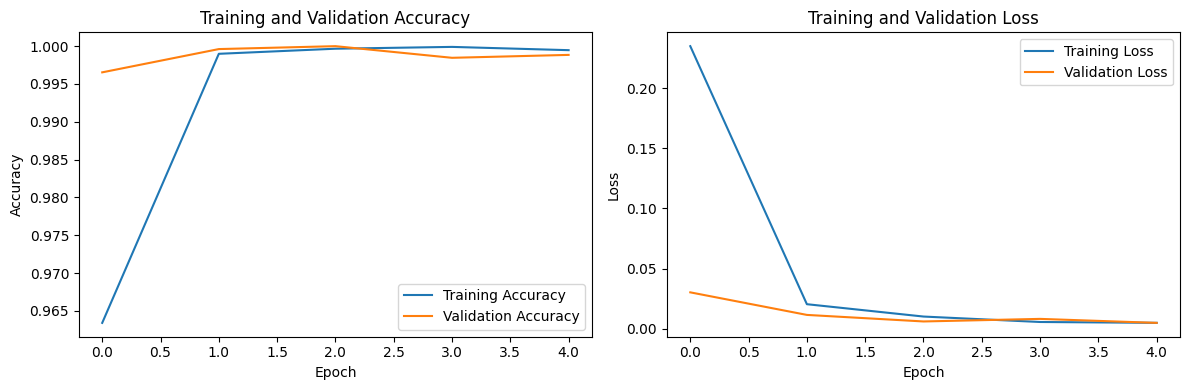

82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9997 - loss: 0.0031
Accuracy on test data: 0.9996
Loss on test data: 0.0043

82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       0.99      1.00      1.00       100
           N       1.00      0.99      0.99

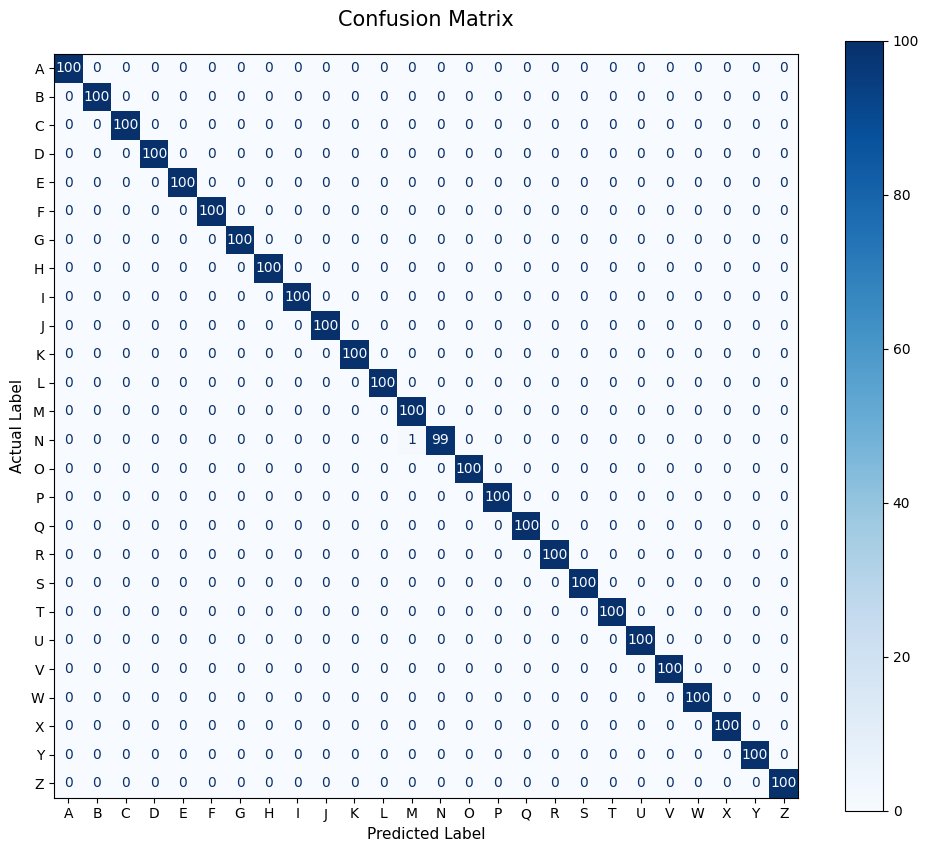

TypeError: upload_and_predict() takes 1 positional argument but 2 were given

In [12]:
resnet_base = custom_model(num_classes, base='resnet', dense_layer_units=None)
resnet_ori, resnet_ori_history = train_model(resnet_base, train_data, val_data, epoch=5)
visualize_history(resnet_ori_history)
print_evaluation(resnet_ori, test_data, class_names)
# upload_and_predict(resnet_ori, class_names)
# save_model(resnet_ori, 'resnet_ori.pkl')

Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


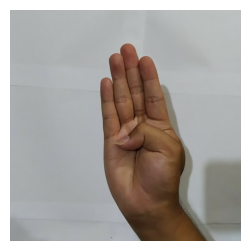

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. B: 53.29%
  2. E: 36.48%
  3. M: 8.42%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


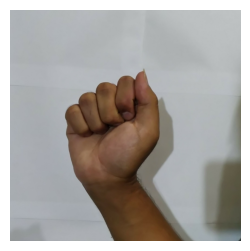

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. A: 93.10%
  2. E: 2.58%
  3. M: 2.26%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


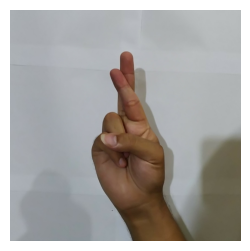

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. K: 82.28%
  2. J: 4.01%
  3. I: 2.76%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


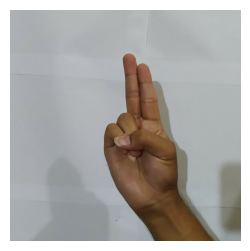

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. C: 19.91%
  2. U: 17.87%
  3. X: 16.40%


In [52]:
predict_images(resnet_ori, class_names, image_directory)

In [24]:
save_model(resnet_ori, 'resnet_ori.pkl')

Instantiating DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_4 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ sequential (Sequential)             │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide (TrueDivide)            │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ add_1 (Add)                         │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide_1 (TrueDivide)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ densenet121 (Functional)            │ (None, 7, 7, 1024)           │     7,037,504 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_1          │ (None, 1024)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 26)                   │        26,650 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 7,064,154 (26.95 MB)

 Trainable params: 26,650 (104.10 KB)

 Non-trainable params: 7,037,504 (26.85 MB)


Create model with base model: densenet, dense layer: None, classes: 26

Start model training...

Epoch 1/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 128s 167ms/step - accuracy: 0.7762 - loss: 1.2438 - val_accuracy: 0.9969 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 2/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 101s 155ms/step - accuracy: 0.9971 - loss: 0.0935 - val_accuracy: 0.9985 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 3/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 101s 155ms/step - accuracy: 0.9986 - loss: 0.0431 - val_accuracy: 0.9992 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 4/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 101s 155ms/step - accuracy: 0.9991 - loss: 0.0251 - val_accuracy: 0.9992 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 5/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 100s 155ms/step - accuracy: 0.9994 - loss: 0.0168 - val_accuracy: 0.9992 - val_loss: 0.0110 - learning_rate: 0.0010

Model training completed.



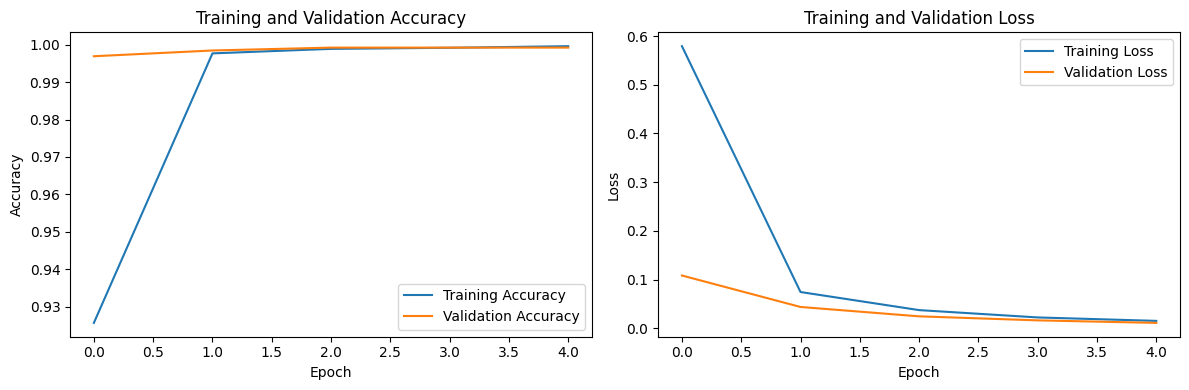

82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9997 - loss: 0.0085
Accuracy on test data: 0.9996
Loss on test data: 0.0097

82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       0.99      1.00      1.00       100
           N       1.00      0.99      0.99

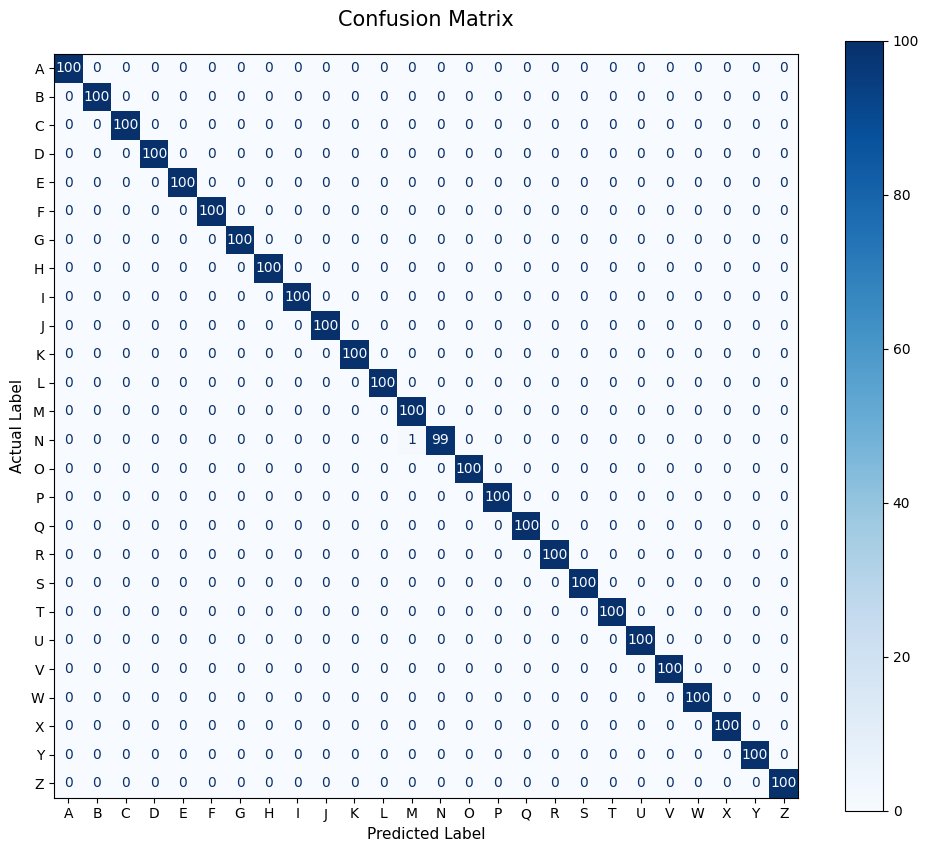

In [27]:
densenet_base = custom_model(num_classes, base='densenet', dense_layer_units=None)
densenet_ori, densenet_ori_history = train_model(densenet_base, train_data, val_data, epoch=5)
visualize_history(densenet_ori_history)
print_evaluation(densenet_ori, test_data, class_names)
# upload_and_predict(densenet_ori, class_names)
save_model(densenet_ori, 'densenet_ori.pkl')

Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


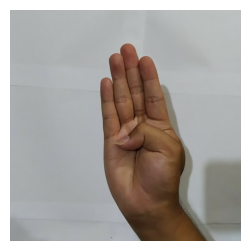

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. E: 67.77%
  2. B: 28.25%
  3. X: 1.54%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


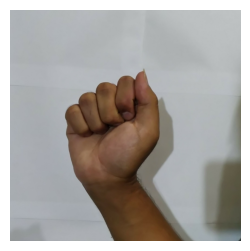

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. E: 36.17%
  2. A: 20.29%
  3. M: 12.51%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


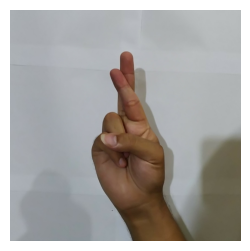

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. X: 58.60%
  2. I: 37.62%
  3. L: 1.64%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


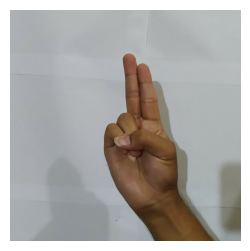

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. F: 38.29%
  2. I: 25.87%
  3. G: 10.19%


In [53]:
predict_images(densenet_ori, class_names, image_directory)

Instantiating MobileNetV2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_6 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ sequential (Sequential)             │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ true_divide_2 (TrueDivide)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ subtract (Subtract)                 │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mobilenetv2_1.00_224 (Functional)   │ (None, 7, 7, 1280)           │     2,257,984 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_2          │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_2 (Dense)                     │ (None, 26)                   │        33,306 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 2,291,290 (8.74 MB)

 Trainable params: 33,306 (130.10 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Create model with base model: mobilenetv2, dense layer: None, classes: 26

Start model training...

Epoch 1/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.8657 - loss: 0.6714 - val_accuracy: 0.9992 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 2/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.9992 - loss: 0.0239 - val_accuracy: 0.9996 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 3/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.9995 - loss: 0.0111 - val_accuracy: 0.9996 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 4/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.9997 - loss: 0.0063 - val_accuracy: 0.9996 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 5/5
650/650 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9996 - val_loss: 0.0035 - learning_rate: 0.0010

Model training completed.



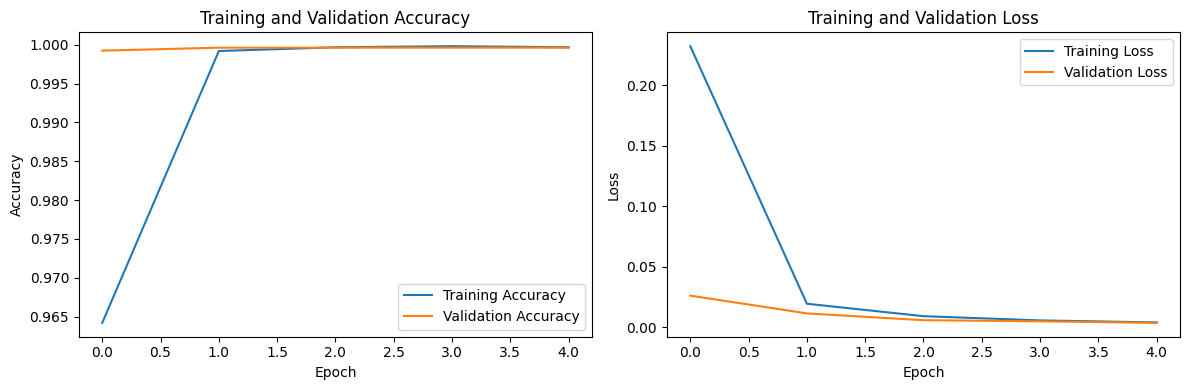

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9999 - loss: 0.0034
Accuracy on test data: 0.9996
Loss on test data: 0.0039

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step

Classification Report :
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       1.00      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00      1.00      1.00       100
           I       1.00      1.00      1.00       100
           J       1.00      1.00      1.00       100
           K       1.00      1.00      1.00       100
           L       1.00      1.00      1.00       100
           M       1.00      1.00      1.00       100
           N       1.00      1.00      1.00    

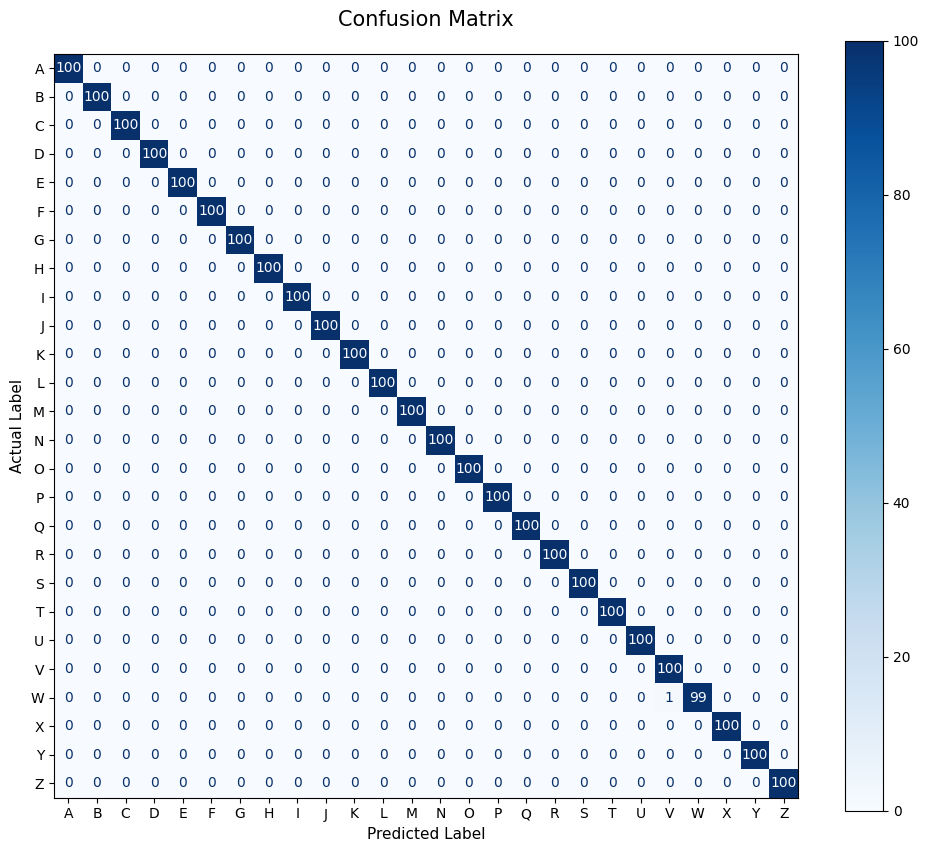

In [35]:
mobilenetv2_base = custom_model(num_classes, base='mobilenetv2', dense_layer_units=None)
mobilenetv2_ori, mobilenetv2_ori_history = train_model(mobilenetv2_base, train_data, val_data, epoch=5)
visualize_history(mobilenetv2_ori_history)
print_evaluation(mobilenetv2_ori, test_data, class_names)
# upload_and_predict(mobilenetv2_ori, class_names)
save_model(mobilenetv2_ori, 'mobilenetv2_ori.pkl')

Searching for images in: '/kaggle/input/new-predict'
Found 4 image(s).

--- Processing file: "/kaggle/input/new-predict/B (4).jpg" ---


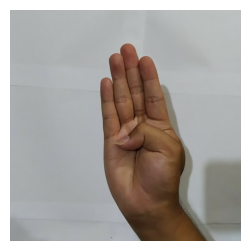

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
--- Prediction Results for "B (4).jpg" ---
Top 3 Predictions:
  1. B: 60.70%
  2. K: 30.67%
  3. A: 2.50%

--- Processing file: "/kaggle/input/new-predict/A (4).jpg" ---


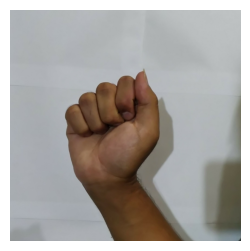

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
--- Prediction Results for "A (4).jpg" ---
Top 3 Predictions:
  1. A: 57.41%
  2. L: 27.36%
  3. J: 6.02%

--- Processing file: "/kaggle/input/new-predict/R (5).jpg" ---


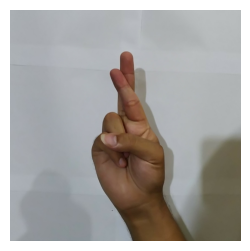

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
--- Prediction Results for "R (5).jpg" ---
Top 3 Predictions:
  1. U: 45.23%
  2. L: 31.08%
  3. K: 14.87%

--- Processing file: "/kaggle/input/new-predict/U (3).jpg" ---


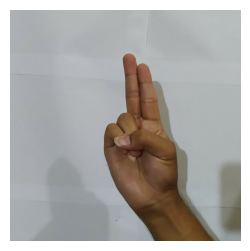

Image preprocessed. Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
--- Prediction Results for "U (3).jpg" ---
Top 3 Predictions:
  1. U: 59.01%
  2. K: 21.25%
  3. L: 16.05%


In [54]:
predict_images(mobilenetv2_ori, class_names, image_directory)